### The main questions of the research is whether a product can be can be classified as a top 5% popular based on early limited data.

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
customers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv")
geolocations = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv")
reviews = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv")
order_items = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv")
orders = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv")
order_payments = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv")

products = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv")
product_category_name_translation = pd.read_csv("/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv")
sellers = pd.read_csv("/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv")

Data quality check
1. Data Quality Checks (Critical)
This is the core of primary analysis.
- Missing Values
For each feature:
% missing
Pattern of missingness (random vs systematic)
Business meaning of missing values
Examples:
Missing review score → customer didn’t leave a review
Missing delivery date → order not delivered yet
- Duplicates
Check duplicates at the correct grain:
Duplicate orders?
Duplicate order_items per (order_id, product_id)?
- Outliers & Invalid Values
Focus on:
Prices ≤ 0
Negative freight values
Extreme delivery times
Extremely high quantities
Decide:
Remove
Cap
Log-transform
Keep (if business-valid)
- Dtypes

2. Relationship & Join Analysis
Since your data is normalized, you must validate joins.
Key checks:
One-to-one vs one-to-many relationships
Duplicate amplification after joins
Missing foreign keys
Example:
orders → order_items (1-to-many)
orders → reviews (0-or-1-to-1)
orders → payments (1-to-many)
👉 Always test joins with row counts before & after.

3. Temporal Analysis (Very Important for Prediction)
E-commerce data is time-dependent.
Check:
Order timestamps
Delivery timestamps
Review timestamps
Payment timestamps
Ensure:
No future information leaks into the past
Proper time ordering
Correct reference date for features
📌 Example:
If predicting late delivery, you must not use actual delivery date as a feature.

4. Exploratory Data Analysis (EDA)
Now explore distributions and relationships.
- Univariate Analysis
Distribution of prices, freight, delivery time
Review score frequency
Payment method usage
- Bivariate Analysis
Delivery time vs review score
Price vs freight
Payment type vs order value
- Segment Analysis
Customer behavior by location
Seller performance by region
Product category performance

5. Feature Feasibility Assessment
Before feature engineering, decide:
For each candidate feature:
Is it available before prediction time?
Is it stable over time?
Is it aggregated correctly?
Examples:
✅ Average delivery delay per seller (past data)
❌ Final review score when predicting delivery delay

6. Granularity Alignment
Choose one modeling level:
Order-level
Customer-level
Product-level
Seller-level
Then aggregate everything to that level.
Example (Order-level model):
Number of items in order
Total order value
Average seller delivery delay (historical)
Customer historical purchase count

7. Target Variable Validation
Check your target:
Class balance (for classification)
Distribution shape (for regression)
Noise and ambiguity
Example:
Review score may be subjective
Delivery delay threshold must be business-defined

8. Data Leakage Audit (Must-Have)
Ask for every feature:
“Would I know this at prediction time?”
Common leakage risks in your datasets:
Using review data to predict delivery
Using delivery date to predict order cancellation
Using future customer behavior

9. Output of Primary Data Analysis
At the end, you should have:
✔ Clean, validated tables
✔ Defined joins and aggregation logic
✔ List of usable features
✔ List of discarded features
✔ Defined prediction timestamp
✔ Clear modeling grain
✔ Leakage-free dataset








Future plans:
1. calculate a metric which will score product popularity or comercial success

As i am planning to build the model for prediction, i need to understand what kind of data i have. \
The model will be a binary (or three class) classifier. \
I need to construct target variable. Then i will be able to explore class balance.\


## 1. Data Quality Check

### 1.1. Data Types

#### datetime

In [3]:
datasets = {"customers": customers,
            "geolocations": geolocations,
            "reviews": reviews,
            "order_items": order_items,
            "orders": orders,
            "order_payments": order_payments,
            "products": products,
            "product_category_name_translation": product_category_name_translation, 
            "sellers":sellers}

In [4]:
reviews["review_creation_date"] = pd.to_datetime(reviews["review_creation_date"], errors="coerce")
reviews["review_answer_timestamp"] = pd.to_datetime(reviews["review_answer_timestamp"], errors="coerce")

order_items["shipping_limit_date"] = pd.to_datetime(order_items["shipping_limit_date"], errors="coerce")

orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"], errors="coerce")
orders["order_delivered_carrier_date"] = pd.to_datetime(orders["order_delivered_carrier_date"], errors="coerce")
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"], errors="coerce")
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"], errors="coerce")
orders["order_approved_at"] = pd.to_datetime(orders["order_approved_at"], errors="coerce")

#### string

In [5]:
obj_features = {name: [feat for feat in dset.columns if dset[feat].dtype.name == "object"] for name, dset in datasets.items()}

for name, dset in datasets.items():
    for feat in obj_features[name]:
        dset[feat] = dset[feat].astype("string")

### 1.2. NAs Check

In [6]:
for name, ds in datasets.items():
    print(name.ljust(50, "#"))
    print(ds.info(), "\n")

customers#########################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  string
 1   customer_unique_id        99441 non-null  string
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  string
 4   customer_state            99441 non-null  string
dtypes: int64(1), string(4)
memory usage: 3.8 MB
None 

geolocations######################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2  

The tables that have NAs 

reviews:
- review_comment_title
- review_comment_message


orders:
- order_delivered_carrier_date
- order_delivered_customer_date
- order_approved_at



products: (NAs are just values someone forgot to fill in - no interpretaion)
- product_category_name
- product_name_lenght
- product_description_lenght
- product_photos_qty 


In [7]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,<NA>,<NA>,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,<NA>,<NA>,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,<NA>,<NA>,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,<NA>,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,<NA>,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


In [8]:
print(
f"""
both are null: {orders[pd.isnull(orders.order_delivered_carrier_date) &
        pd.isna(orders.order_delivered_customer_date)].shape[0]}
        
customer isn't null but carrier is null: {orders[pd.isnull(orders.order_delivered_carrier_date) &
        pd.notna(orders.order_delivered_customer_date)].shape[0]}
        
carrier isn't null but cutomer is null: {orders[pd.notnull(orders.order_delivered_carrier_date) &
        pd.isna(orders.order_delivered_customer_date)].shape[0]}
"""
)


both are null: 1782
        
customer isn't null but carrier is null: 1
        
carrier isn't null but cutomer is null: 1183



In [9]:
orders[pd.isna(orders.order_approved_at)].value_counts("order_status")

order_status
canceled     141
delivered     14
created        5
Name: count, dtype: int64

### 1.3 Dealing with NAs

reviews:\
I will not use reviews table columns: review_comment_title	and review_comment_message for prediction model construction as they have to many missing values.

orders:\
I will not drop any observations from orders dataset, because there are no missing values in teh columsn I ma going to use.


In [10]:
na_cols = ["product_category_name",
"product_name_lenght",
"product_description_lenght",
"product_photos_qty"]

mask_all = products[na_cols].isna().all(axis=1)

#check if NaN values are in the same rows for all the columns listed in na_cols
assert all([products[products[c].isna()].shape == products[mask_all].shape for  c in na_cols])

In [11]:
products.isna().any(axis=1).value_counts()

False    32340
True       611
Name: count, dtype: int64

In [12]:
products = products.dropna()

All the rows with NaN in na_cols can be dropped as NaN values are in the same rows for all the columns listed in na_cols.

### 1.4. Duplicated IDs

Some of the reviews are duplicated with only order id changed. That might mean that riviews can have more than one order id.

In [13]:
reviews[reviews.review_id == reviews[reviews.review_id.duplicated()].iloc[1, 0]]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
4545,308316408775d1600dad81bd3184556d,27e5ed2ecefbe0bcc9ae0c9b26b763c3,5,<NA>,Ajudem a rastrear uma das 3 prateleiras que fa...,2017-09-07,2017-09-11 09:58:09
5719,308316408775d1600dad81bd3184556d,3fe4dbcdb046a475dbf25463c1ca78bd,5,<NA>,Ajudem a rastrear uma das 3 prateleiras que fa...,2017-09-07,2017-09-11 09:58:09
53661,308316408775d1600dad81bd3184556d,8b3c2785144e72ccba9b0213f0f1cd1e,5,<NA>,Ajudem a rastrear uma das 3 prateleiras que fa...,2017-09-07,2017-09-11 09:58:09


However the orders look different.

In [14]:
order_ids = reviews[reviews.review_id == reviews[reviews.review_id.duplicated()].iloc[1, 0]].order_id
orders.loc[orders.order_id.isin(order_ids)]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3804,3fe4dbcdb046a475dbf25463c1ca78bd,e17387227a12c3cac59fc44523d162e5,delivered,2017-08-30 06:22:58,2017-08-30 07:00:08,2017-08-30 20:43:45,2017-09-06 18:42:36,2017-09-26
14178,8b3c2785144e72ccba9b0213f0f1cd1e,e6138dce24962a66623898c89db41ef7,delivered,2017-08-30 06:22:57,2017-08-30 07:00:05,2017-08-30 20:43:45,2017-09-06 20:27:43,2017-09-26
55653,27e5ed2ecefbe0bcc9ae0c9b26b763c3,9962a28bb74e0754415433c3ddc14b2f,delivered,2017-08-30 06:22:58,2017-08-30 07:00:06,2017-08-30 20:43:45,2017-09-11 21:06:49,2017-09-26


Some orders have more than one payment.

In [15]:
order_payments[order_payments.order_id.duplicated()].shape

(4446, 5)

However all the payments are unique

In [16]:
order_payments[order_payments.duplicated()].shape

(0, 5)

Non of the order ids are duplicated

In [17]:
orders[orders.order_id.duplicated()].shape

(0, 8)

In [18]:
customers[customers.customer_id.duplicated()].shape, customers[customers.customer_unique_id.duplicated()].shape

((0, 5), (3345, 5))

In [19]:
products[products.product_id.duplicated()].shape

(0, 9)

In [20]:
order_items[order_items.duplicated()].shape

(0, 7)

In [21]:
sellers[sellers.seller_id.duplicated()].shape

(0, 4)

261831 of geolocations are duplicated in geolocations dataset

In [22]:
geolocations[geolocations.duplicated()].shape

(261831, 5)

## 2. Relationship & Join Analysis

![My image](https://i.imgur.com/HRhd2Y0.jpg)

olist_order_customers_dataset.csv name was changed to olist_customers_dataset.csv

### 2.1 one-to-one

Check whether any missing values, duplicates or another problems appear when merging one to one.

In [23]:
orders.shape, customers.shape

((99441, 8), (99441, 5))

In [24]:
pd.merge(orders, customers).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  string        
 1   customer_id                    99441 non-null  string        
 2   order_status                   99441 non-null  string        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   customer_unique_id             99441 non-null  string        
 9   customer_zip_code_prefix       99441 non-null  int64         
 10  customer_city                  99441 non-null  string        
 11  customer_state 

In [25]:
pd.merge(order_items, products).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111046 entries, 0 to 111045
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   order_id                    111046 non-null  string        
 1   order_item_id               111046 non-null  int64         
 2   product_id                  111046 non-null  string        
 3   seller_id                   111046 non-null  string        
 4   shipping_limit_date         111046 non-null  datetime64[ns]
 5   price                       111046 non-null  float64       
 6   freight_value               111046 non-null  float64       
 7   product_category_name       111046 non-null  string        
 8   product_name_lenght         111046 non-null  float64       
 9   product_description_lenght  111046 non-null  float64       
 10  product_photos_qty          111046 non-null  float64       
 11  product_weight_g            111046 non-

### 2.2 many-to-one

In [26]:
reviews.shape, orders.shape

((99224, 7), (99441, 8))

In [27]:
pd.merge(reviews, orders).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   review_id                      99224 non-null  string        
 1   order_id                       99224 non-null  string        
 2   review_score                   99224 non-null  int64         
 3   review_comment_title           11568 non-null  string        
 4   review_comment_message         40977 non-null  string        
 5   review_creation_date           99224 non-null  datetime64[ns]
 6   review_answer_timestamp        99224 non-null  datetime64[ns]
 7   customer_id                    99224 non-null  string        
 8   order_status                   99224 non-null  string        
 9   order_purchase_timestamp       99224 non-null  datetime64[ns]
 10  order_approved_at              99068 non-null  datetime64[ns]
 11  order_delivered

In [28]:
order_payments.shape, orders.shape, 

((103886, 5), (99441, 8))

In [29]:
pd.merge(order_payments, orders).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       103886 non-null  string        
 1   payment_sequential             103886 non-null  int64         
 2   payment_type                   103886 non-null  string        
 3   payment_installments           103886 non-null  int64         
 4   payment_value                  103886 non-null  float64       
 5   customer_id                    103886 non-null  string        
 6   order_status                   103886 non-null  string        
 7   order_purchase_timestamp       103886 non-null  datetime64[ns]
 8   order_approved_at              103711 non-null  datetime64[ns]
 9   order_delivered_carrier_date   101998 non-null  datetime64[ns]
 10  order_delivered_customer_date  100754 non-null  datetime64[ns]
 11  

Some orders have two or more payments.

In [30]:
# order_payments[order_payments.duplicated("order_id")].sort_values(by="order_id")

order_payments.loc[order_payments.order_id == "009ac365164f8e06f59d18a08045f6c4", :]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
285,009ac365164f8e06f59d18a08045f6c4,5,voucher,1,8.75
15298,009ac365164f8e06f59d18a08045f6c4,6,voucher,1,4.17
16053,009ac365164f8e06f59d18a08045f6c4,1,credit_card,1,0.88
16459,009ac365164f8e06f59d18a08045f6c4,2,voucher,1,4.50
32058,009ac365164f8e06f59d18a08045f6c4,4,voucher,1,5.45
73837,009ac365164f8e06f59d18a08045f6c4,3,voucher,1,8.25


In [31]:
pd.merge(order_items, orders).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  string        
 1   order_item_id                  112650 non-null  int64         
 2   product_id                     112650 non-null  string        
 3   seller_id                      112650 non-null  string        
 4   shipping_limit_date            112650 non-null  datetime64[ns]
 5   price                          112650 non-null  float64       
 6   freight_value                  112650 non-null  float64       
 7   customer_id                    112650 non-null  string        
 8   order_status                   112650 non-null  string        
 9   order_purchase_timestamp       112650 non-null  datetime64[ns]
 10  order_approved_at              112635 non-null  datetime64[ns]
 11  

In [32]:
geolocations.shape, customers.shape

((1000163, 5), (99441, 5))

In [33]:
pd.merge(customers,
         geolocations, 
         left_on="customer_zip_code_prefix", 
         right_on="geolocation_zip_code_prefix").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15083455 entries, 0 to 15083454
Data columns (total 10 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   customer_id                  string 
 1   customer_unique_id           string 
 2   customer_zip_code_prefix     int64  
 3   customer_city                string 
 4   customer_state               string 
 5   geolocation_zip_code_prefix  int64  
 6   geolocation_lat              float64
 7   geolocation_lng              float64
 8   geolocation_city             string 
 9   geolocation_state            string 
dtypes: float64(2), int64(2), string(6)
memory usage: 1.1 GB


The analysis of this merge will stop there because this merge is to large to count non null values and also geolocations of customers will not be necessary for model.

In [34]:
order_items.shape, sellers.shape

((112650, 7), (3095, 4))

In [35]:
pd.merge(sellers, order_items).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   seller_id               112650 non-null  string        
 1   seller_zip_code_prefix  112650 non-null  int64         
 2   seller_city             112650 non-null  string        
 3   seller_state            112650 non-null  string        
 4   order_id                112650 non-null  string        
 5   order_item_id           112650 non-null  int64         
 6   product_id              112650 non-null  string        
 7   shipping_limit_date     112650 non-null  datetime64[ns]
 8   price                   112650 non-null  float64       
 9   freight_value           112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), string(5)
memory usage: 8.6 MB


Seller dataset and geolocation dataset merge will not be analysed because it is to large

## 3. Temporal Analysis

#### Time features:
review_creation_date\
review_answer_timestamp\
shipping_limit_date\
order_purchase_timestamp\
order_delivered_carrier_date\
order_delivered_customer_date\
order_estimated_delivery_date

#### Temporal analysis plan:
1. order_purchase_timestamp <= order_delivered_carrier_date <= order_delivered_customer_date 

2. order_delivered_customer_date <= review_creation_date <= review_answer_timestamp

3. order_estimated_delivery_date vs order_delivered_carrier_date

4. End-to-End Order Duration Relationships\
processing_time =	delivered_carrier - purchase\
shipping_time	= delivered_customer - delivered_carrier\
total_delivery_time	= delivered_customer - purchase\
estimated_delivery_window =	estimated_delivery - purchase\
review_delay	= review_creation - delivered_customer\
answer_delay	= review_answer - review_creation\
Look for:\
negative values, extreme outliers, heavy skew \
These reveal data leakage, missing events, or broken timestamps.

5. Business-Logic Distribution Checks
Check if the following make sense:\
Metric	Typical Expectation\
processing_time:	Hours–days\
shipping_time:	Days–weeks\
total_delivery_time:	Days–weeks\
review_delay:	Hours–weeks\
answer_delay:	Hours–days\
If you see negative medians, multi-year values, or huge spikes → strong red flag.

6. Missingness and Partial Order Logic
Important patterns:\
order_delivered_customer_date missing but review exists → ❌ suspicious\
review exists but no delivery → ❌\
estimated exists but actual delivery missing → possibly canceled\
delivered_carrier exists but delivered_customer missing → in transit or lost\
These patterns help you classify order status anomalies.

shipping_limit_date - shows the seller shipping limit date for handling the order over to the logistic partner.

### 3.1  order_purchase_tiemstamp <= order_approved_at

In [36]:
# time difference in days
approval_time  = (orders["order_approved_at"] - orders["order_purchase_timestamp"]).dt.total_seconds() / 3600 / 24
approval_time[approval_time < 0].shape

(0,)

In [37]:
bins = pd.cut(approval_time, bins=20).value_counts()
bins[bins > 0]

(-0.188, 9.394]       99232
(9.394, 18.788]          38
(28.182, 37.577]          5
(18.788, 28.182]          4
(56.365, 65.759]          1
(178.488, 187.883]        1
Name: count, dtype: int64

### 3.2.1 order_purchase_timestamp <= order_delivered_carrier_date <= order_delivered_customer_date

For 166 observations have order_delivered_carrier_date happended erlier than order_purchase_timestamp, which is an anomaly.

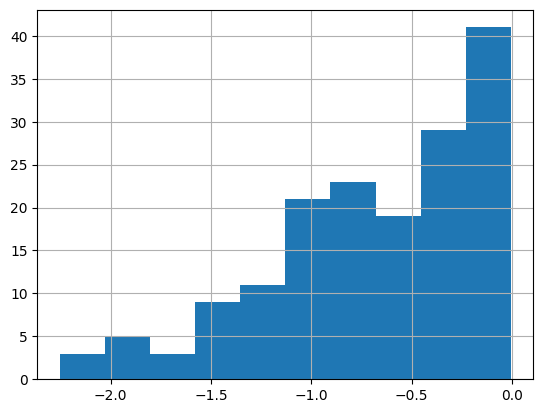

In [38]:
# difference in hours
processing_time  = (orders["order_delivered_carrier_date"] - orders["order_purchase_timestamp"]).dt.total_seconds() / 3600

processing_time_neg = processing_time[processing_time < 0]
processing_time_neg_outliers = processing_time_neg[processing_time_neg < -100]

processing_time_neg[processing_time_neg > -100].hist();

 Also two of them have extremely large differences

In [39]:
processing_time_neg.shape

(166,)

For 23 observations order_delivered_carrier_date > order_delivered_customer_date, which is an anomaly.

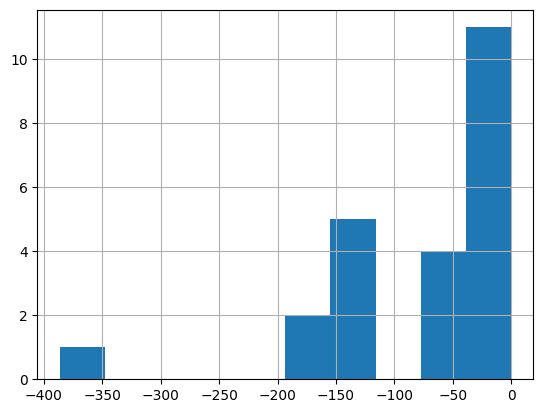

In [40]:
shipping_time = (orders["order_delivered_customer_date"] - orders["order_delivered_carrier_date"]).dt.total_seconds() / 3600
shipping_time_neg = shipping_time[shipping_time < 0]
shipping_time_neg.hist();

However purchase time percedes delivery to customer timestamp for every order.

In [41]:
total_delivery_time  = (orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]).dt.total_seconds() / 3600
total_delivery_time_neg = total_delivery_time[total_delivery_time < 0]
total_delivery_time_neg.shape

(0,)

### 3.2.2 order_approved_at <= order_delivered_carrier_date && order_approved_at <= order_delivered_customer_date

In [42]:
# difference in hours
appr_to_car  = (orders["order_delivered_carrier_date"] - orders["order_approved_at"]).dt.total_seconds() / 3600

appr_to_car_neg = appr_to_car[appr_to_car < 0]

bins = pd.cut(appr_to_car_neg, bins=100).value_counts()
bins[bins > 0]

(-41.098, -0.00583]       1166
(-82.191, -41.098]         121
(-123.283, -82.191]         45
(-164.376, -123.283]        13
(-246.561, -205.468]         8
(-205.468, -164.376]         5
(-4113.365, -4068.164]       1
Name: count, dtype: int64

In [43]:
appr_to_car_neg.shape

(1359,)

1359 orders were delivered to carrier before they were approved.

<Axes: >

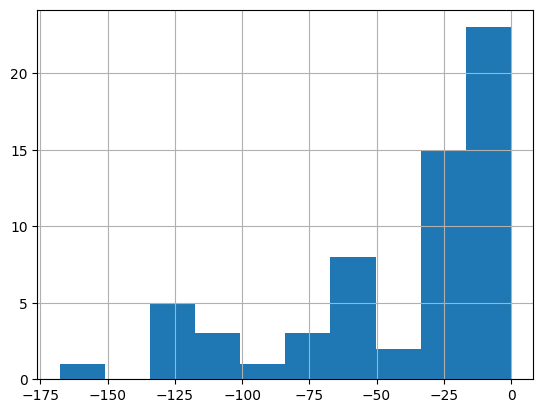

In [44]:
appr_to_cust = (orders["order_delivered_customer_date"] - orders["order_approved_at"]).dt.total_seconds() / 3600
appr_to_cust_neg = appr_to_cust[appr_to_cust < 0]
appr_to_cust_neg.hist()

<Axes: >

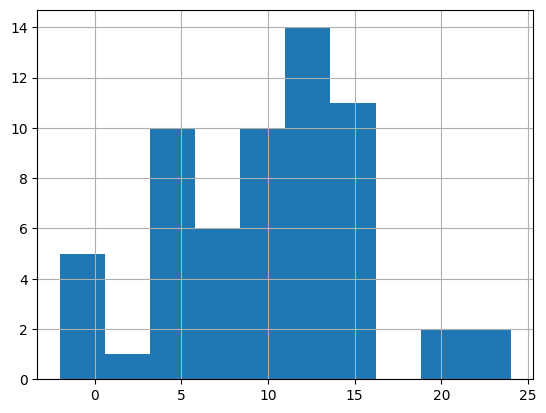

In [45]:
late_approved = orders[appr_to_cust < 0]


(late_approved["order_estimated_delivery_date"] - late_approved["order_delivered_customer_date"]).dt.days.hist()

According to the histogram above almost all the orders which were deliverd before the approval also were deliverd earlier than the estimated delivery date. It might mean that the orders were delivered faster than the sercive could approve custumers payment.

### 3.3. order_delivered_customer_date <= review_creation_date <= review_answer_timestamp

review_creation_date show when the satisfaction survey was sent to a customer. The survey has been sent by 544 more times before customer recieved the order than after recieving it.

In [46]:
cust_to_rev  = (reviews["review_creation_date"] - orders["order_delivered_customer_date"]).dt.total_seconds() / 3600
cust_to_rev[cust_to_rev < 0].shape[0] - cust_to_rev[cust_to_rev > 0].shape[0]

544

<Axes: >

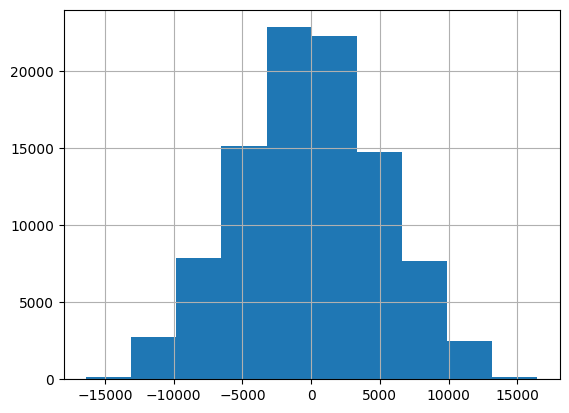

In [47]:
cust_to_rev.hist()

Review answering was always after review creation.

In [48]:
answer_delay  = (reviews["review_answer_timestamp"] - reviews["review_creation_date"]).dt.total_seconds() / 3600
answer_delay_neg = answer_delay[answer_delay < 0]
answer_delay_neg.shape

(0,)

### seller shipping time limit

<Axes: >

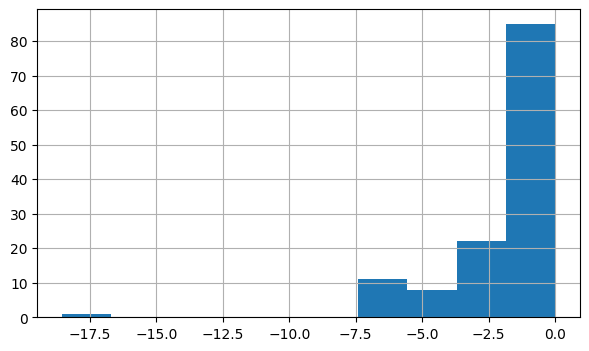

In [49]:
shipping_limit = (order_items["shipping_limit_date"] - pd.merge(order_items, orders, on="order_id")["order_approved_at"]).dt.total_seconds() / 3600 / 24
shipping_limit[shipping_limit < 0].hist(figsize=(7, 4))

Some of the time limits were set before the order has been approved.

In [50]:
bins = pd.cut(shipping_limit, bins=int((shipping_limit.max() - shipping_limit.min())/10)).value_counts()
bins[bins > 0]

(1.543, 11.586]         106094
(11.586, 21.629]          5541
(-8.5, 1.543]              490
(21.629, 31.671]           289
(31.671, 41.714]           159
(41.714, 51.757]            51
(1045.999, 1056.042]         4
(91.928, 101.971]            2
(61.8, 71.843]               1
(81.886, 91.928]             1
(71.843, 81.886]             1
(142.143, 152.186]           1
(-19.617, -8.5]              1
Name: count, dtype: int64

The majority of orders have time limit between 1.5 days and 2 weeks.

### seller shipping limit date vs delivered to carrier date

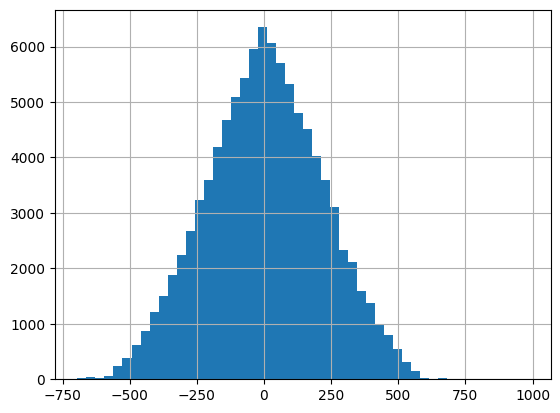

In [51]:
shipping_delay = (order_items["shipping_limit_date"] - orders["order_delivered_carrier_date"]).dt.total_seconds() / 3600 / 24
shipping_delay.hist(bins=50);

According to the histogram the differences between shipping limit date and the real date when carrier received an order were random.

## payment approval 

### 3.4. order_estimated_delivery_date vs order_delivered_carrier_date



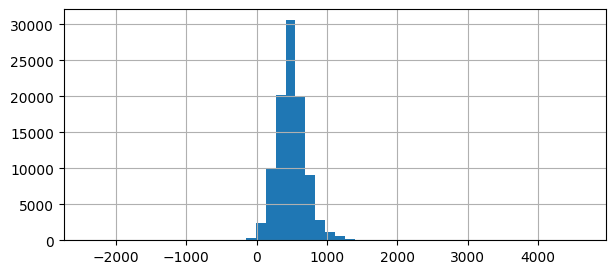

In [52]:
est_vs_real = (orders["order_estimated_delivery_date"] - orders["order_delivered_carrier_date"]).dt.total_seconds() / 3600
est_vs_real.hist(bins=50, figsize=(7, 3));

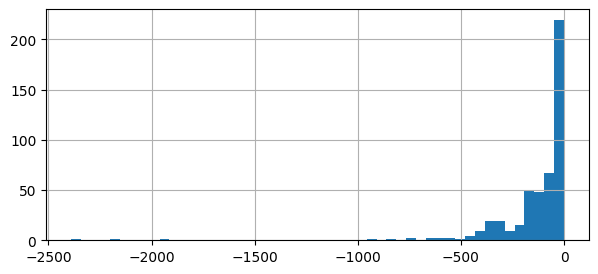

In [53]:
est_vs_real[est_vs_real < 0].hist(bins=50, figsize=(7, 3));

In [54]:
est_vs_real[est_vs_real > 0].shape[0] / est_vs_real.shape[0]

0.9773131806800012

In [55]:
est_vs_real_pos = est_vs_real[est_vs_real > 0]
est_vs_real_pos[int(est_vs_real_pos.sort_values().shape[0]*0.975)].mean()

np.float64(202.11666666666667)

Acctual delivery time is longer than esimated delivery time in 98% of cases. Excluding outliers this difference is 202 hours on average.

### 3.5. Outliers

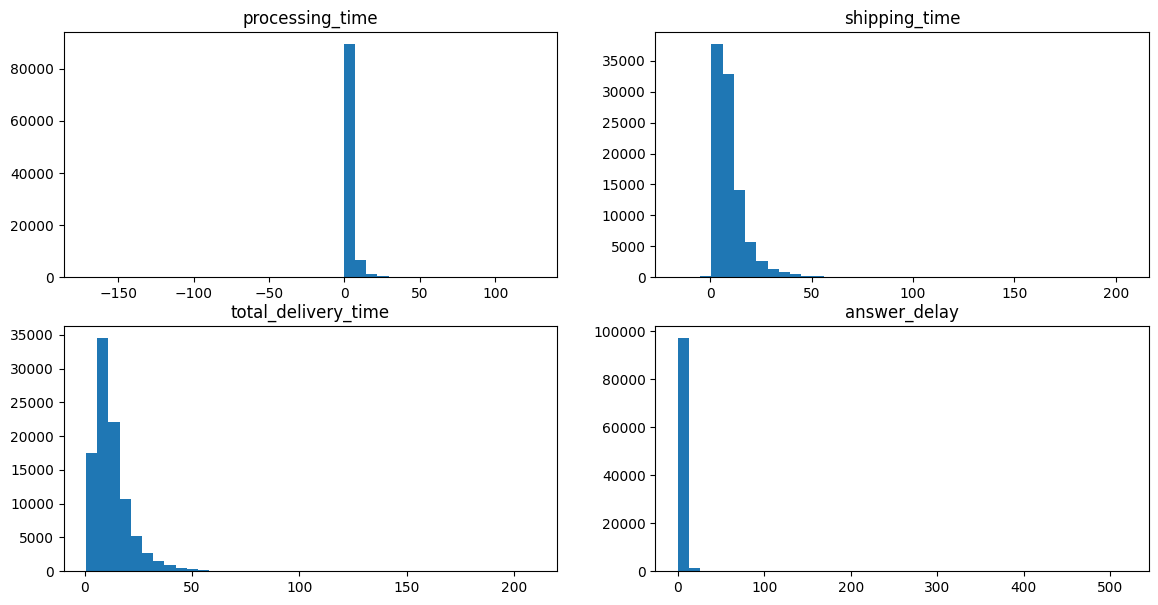

In [56]:
metrics = {"processing_time": processing_time.dropna() / 24 , 
          "shipping_time": shipping_time.dropna() / 24, 
          "total_delivery_time": total_delivery_time.dropna() / 24,
          "answer_delay": answer_delay.dropna() / 24}

met_names = (name for name in metrics.keys())
fig, ax = plt.subplots(2, 2, figsize=(14, 7))
k = 0  # index for num_cols
for i in range(2):
    for j in range(2):
        try:
            name = next(met_names)
            ax[i, j].hist(metrics[name], bins=40)
            ax[i, j].set_title(name)
        except:
            ax[i, j].axis('off')

In [57]:
for name, feature in metrics.items():
    n = len(feature)
    bins = pd.cut(feature.sort_values()[int(n*0.995):], bins=5).value_counts()
    print(name.center(30, "#"), "\n", bins, "\n")
    

#######processing_time######## 
 (22.063, 42.888]      453
(42.888, 63.61]        32
(105.054, 125.776]      2
(63.61, 84.332]         1
(84.332, 105.054]       1
Name: count, dtype: int64 

########shipping_time######### 
 (48.72, 80.14]        398
(80.14, 111.402]       41
(111.402, 142.665]     17
(173.928, 205.191]     14
(142.665, 173.928]     13
Name: count, dtype: int64 

#####total_delivery_time###### 
 (53.904, 85.173]      396
(85.173, 116.287]      42
(116.287, 147.401]     20
(178.515, 209.629]     14
(147.401, 178.515]     11
Name: count, dtype: int64 

#########answer_delay######### 
 (39.336, 135.592]     381
(135.592, 231.369]     71
(231.369, 327.146]     31
(327.146, 422.922]      8
(422.922, 518.699]      6
Name: count, dtype: int64 



## 4. EDA

### 4.1 Univariate Analysis

<Axes: xlabel='review_score'>

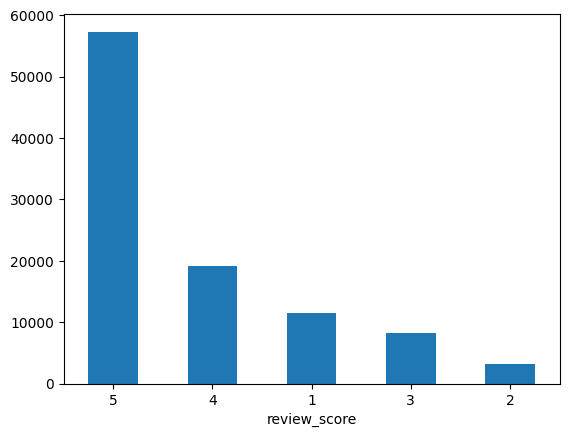

In [58]:
reviews.review_score.value_counts().plot.bar(x="review_score", rot=0)

From this plot we can say that review_scores will not be a valuable feature to identify potentialy popular products as the majority of ordrs are scored as 5.

<Axes: xlabel='payment_sequential'>

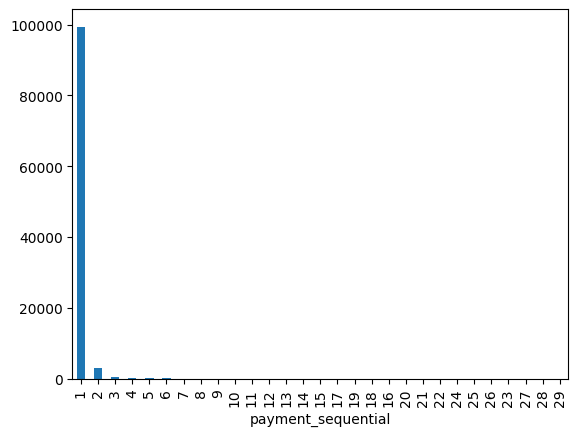

In [59]:
order_payments.payment_sequential.value_counts().plot.bar(x="index")

<Axes: xlabel='payment_installments'>

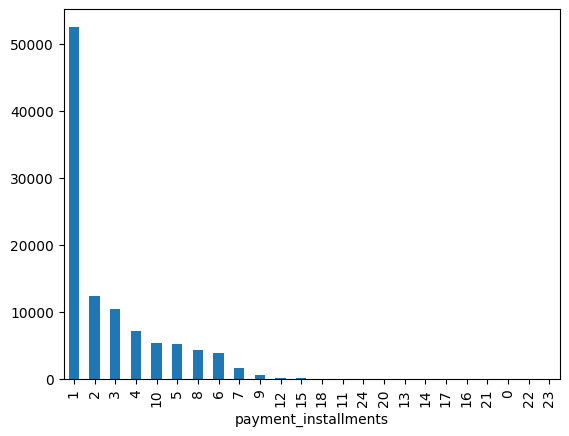

In [60]:
order_payments.payment_installments.value_counts().plot.bar(x="index")

In [61]:
order_payments.payment_type.value_counts()

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: Int64

<Axes: >

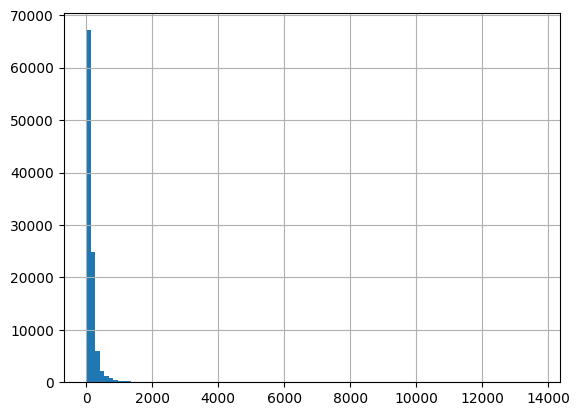

In [62]:
order_payments.payment_value.hist(bins=100)

In [63]:
order_payments[order_payments.payment_value == 0]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
19922,8bcbe01d44d147f901cd3192671144db,4,voucher,1,0.0
36822,fa65dad1b0e818e3ccc5cb0e39231352,14,voucher,1,0.0
43744,6ccb433e00daae1283ccc956189c82ae,4,voucher,1,0.0
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
62674,45ed6e85398a87c253db47c2d9f48216,3,voucher,1,0.0
77885,fa65dad1b0e818e3ccc5cb0e39231352,13,voucher,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0
100766,b23878b3e8eb4d25a158f57d96331b18,4,voucher,1,0.0


In [64]:
orders.order_status.value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: Int64

In [65]:
customers.customer_city.unique().shape

(4119,)

In [66]:
customers.customer_zip_code_prefix.unique().shape

(14994,)

<Axes: xlabel='customer_state'>

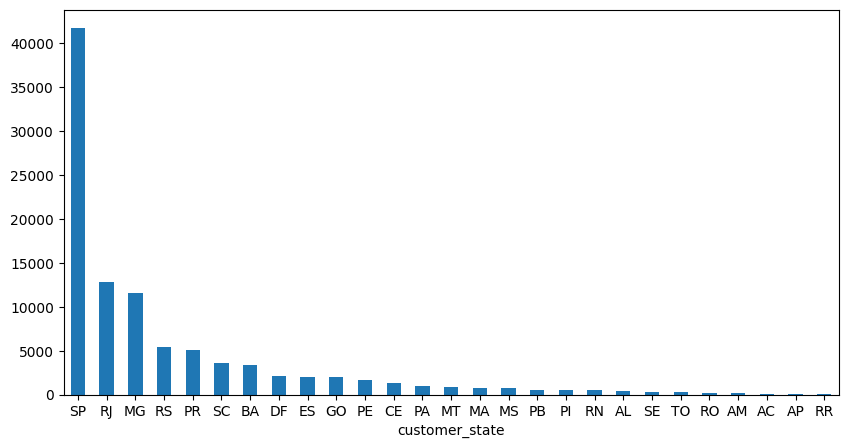

In [67]:
customers.customer_state.value_counts().plot.bar(rot=0,  figsize=(10, 5))

In [68]:
products.product_category_name.value_counts()

product_category_name
cama_mesa_banho                  3029
esporte_lazer                    2867
moveis_decoracao                 2657
beleza_saude                     2444
utilidades_domesticas            2335
                                 ... 
fashion_roupa_infanto_juvenil       5
casa_conforto_2                     5
pc_gamer                            3
seguros_e_servicos                  2
cds_dvds_musicais                   1
Name: count, Length: 73, dtype: Int64

In [69]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [70]:
mapping = {key: val for (key, val) in zip(product_category_name_translation.product_category_name,
                                product_category_name_translation.product_category_name_english)}
products["product_category_name_eng"] = products.product_category_name.map(mapping)

/tmp/ipykernel_17/2467459640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products["product_category_name_eng"] = products.product_category_name.map(mapping)


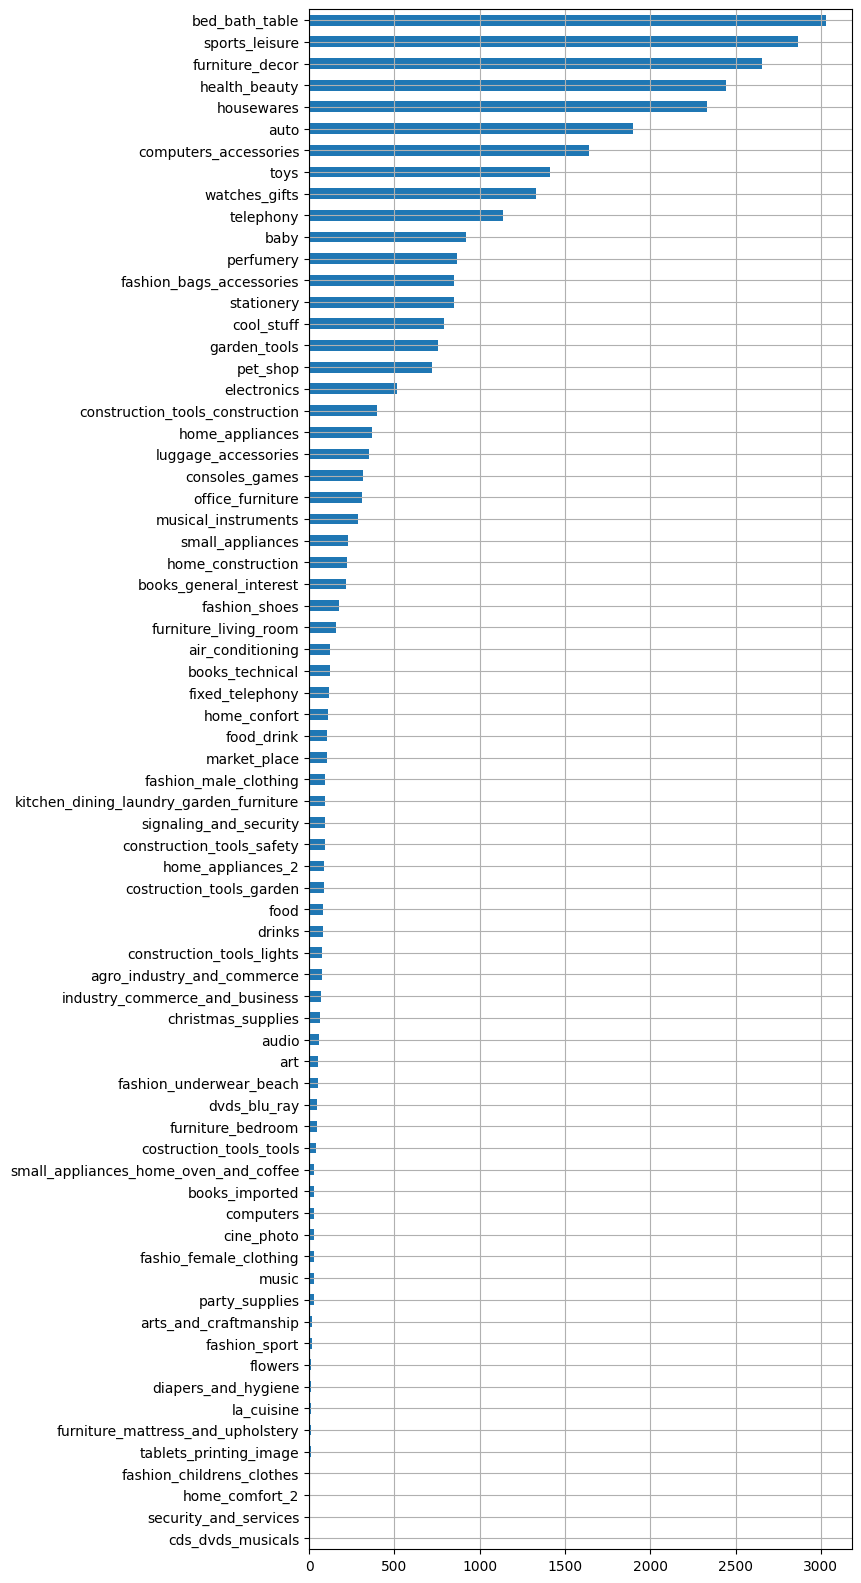

In [71]:
products.product_category_name_eng.value_counts().sort_values().plot.barh(figsize=(7, 20), 
                                                                         ylabel="",
                                                                         grid=True);

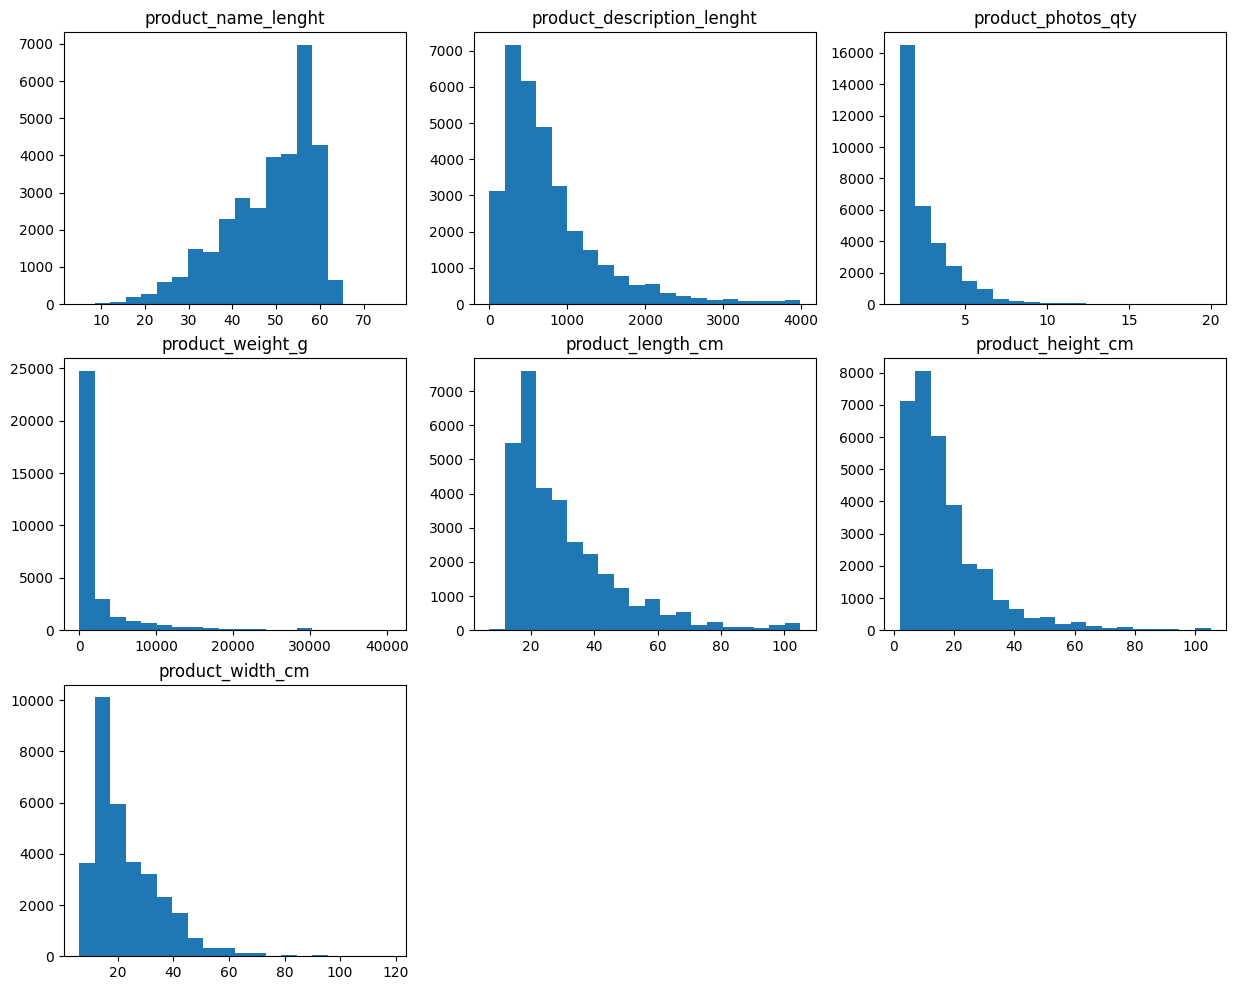

In [72]:
num_cols = products.select_dtypes("float64").columns
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
k = 0  # index for num_cols
for i in range(3):
    for j in range(3):
        if k < len(num_cols):
            ax[i, j].hist(products[num_cols[k]], bins=20)
            ax[i, j].set_title(num_cols[k])
            k += 1
        else:
            ax[i, j].axis('off')

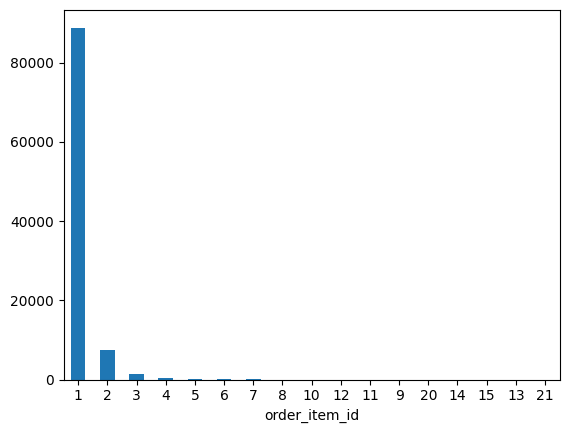

In [73]:
#Number of orders by the number of items in the order
order_items.groupby("order_id").order_item_id.count().value_counts().plot.bar(rot=0);

In [74]:
#sum to get the total freight value because each item in the order has its own freight value
bins = pd.cut(order_items.groupby("order_id").freight_value.sum(), bins=100).value_counts()
bins[bins > 0]

freight_value
(-1.795, 17.95]        53872
(17.95, 35.899]        32264
(35.899, 53.849]        7342
(53.849, 71.798]        2642
(71.798, 89.748]        1058
(89.748, 107.698]        569
(107.698, 125.647]       284
(125.647, 143.597]       195
(143.597, 161.546]       126
(161.546, 179.496]        93
(179.496, 197.446]        57
(197.446, 215.395]        37
(215.395, 233.345]        25
(251.294, 269.244]        20
(233.345, 251.294]        16
(269.244, 287.194]        12
(305.143, 323.093]        11
(323.093, 341.042]        10
(287.194, 305.143]         7
(341.042, 358.992]         6
(358.992, 376.942]         4
(376.942, 394.891]         3
(394.891, 412.841]         2
(448.74, 466.69]           2
(484.639, 502.589]         2
(430.79, 448.74]           1
(466.69, 484.639]          1
(502.589, 520.538]         1
(610.286, 628.236]         1
(1777.01, 1794.96]         1
(987.228, 1005.178]        1
(700.034, 717.984]         1
Name: count, dtype: int64

In [75]:
sellers.seller_city.value_counts().head(10)

seller_city
sao paulo         694
curitiba          127
rio de janeiro     96
belo horizonte     68
ribeirao preto     52
guarulhos          50
ibitinga           49
santo andre        45
campinas           41
maringa            40
Name: count, dtype: Int64

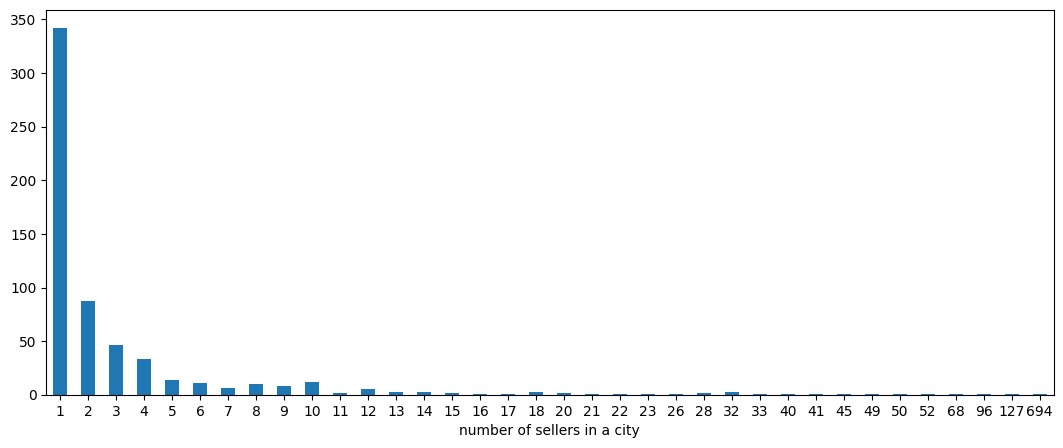

In [76]:
# number of citeis by the number of selelrs in them
sellers.seller_city.value_counts().value_counts().sort_index(ascending=True).plot.bar(rot=0, figsize=(13, 5), xlabel="number of sellers in a city");

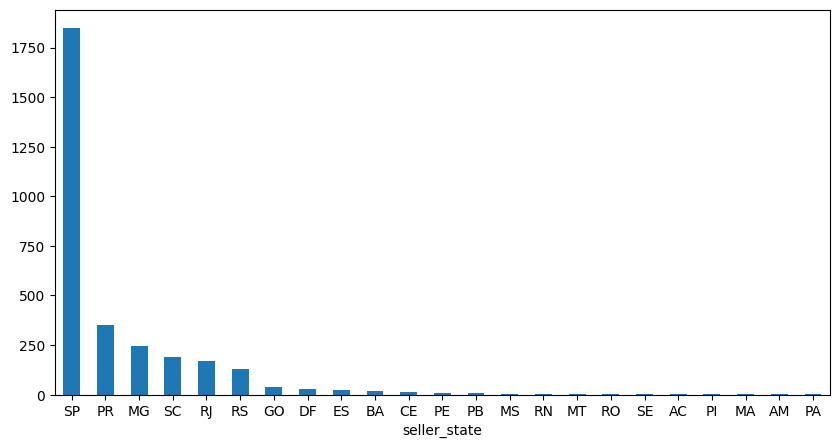

In [77]:
sellers.seller_state.value_counts().plot.bar(rot=0, figsize=(10, 5));

### 4.2 Bivariate Analysis

There will be every two feature analysis required for model construction.

In [78]:
max_name = max(len(name) for name in datasets.keys())
max_feat = max(len(feat) for name, dset in datasets.items() for feat in dset.columns)
for dname, dset in datasets.items():
    features = [item.ljust(max_feat + 3) for item in dset.columns[dset.columns.str.find("id") < 0]]
    if len(features) > 3:
        print(dname.ljust(max_name), ":", "".join(features[:3]), "\n\n",
              " "*(max_name + 1), "".join(features[3:]), "\n\n")
    else:
        print(dname.ljust(max_name), ":", "".join(features), "\n\n")
        
  

customers                         : customer_zip_code_prefix        customer_city                   customer_state                   


geolocations                      : geolocation_zip_code_prefix     geolocation_lat                 geolocation_lng                  

                                    geolocation_city                geolocation_state                


reviews                           : review_score                    review_comment_title            review_comment_message           

                                    review_creation_date            review_answer_timestamp          


order_items                       : shipping_limit_date             price                           freight_value                    


orders                            : order_status                    order_purchase_timestamp        order_approved_at                

                                    order_delivered_carrier_date    order_delivered_customer_date   order_estimated

## 5. Target construction

Model will predict if the product will get to 5% of most popular.
- How to define product popularity?
- What time period will be set for prediction? (information aquired in the first week)
- when will be teh moment to decide if teh product is popular? (a year after the first purchase or few months?)

Which features?:
- how many purchases
- which region/city the purchases were mostly from


In [79]:
# order_items.groupby("product_id").counts()